In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.neighbors import KDTree
from sklearn.metrics import pairwise_distances

In [2]:
def read_pslg(file_name):
    """Read data from pslg file
    Params:
        file_name (str): the absolute path for the file
    Returns:
        data (np.array)
        connect_left
        connect_right
    """
    with open(file_name, "r") as fp:
        components = fp.read().split("component: ")[1:]
        
    lpoints, lconnect_left, lconnect_right = [], [], []
    index = 0
        
    for component in components:
        raw_points = component.split("\n")[1:-1]
        points = [list(map(float, line.split()[1:3])) for line in raw_points]
        connect_left = np.roll(np.arange(index, index + len(raw_points), 1), -1)
        connect_right = np.roll(connect_left, 2)
        
        lpoints = lpoints + points
        lconnect_left.append(connect_left)
        lconnect_right.append(connect_right)
        
        index += len(raw_points)
        
    return np.array(lpoints), np.hstack(lconnect_left).astype(int), np.hstack(lconnect_right).astype(int)

In [3]:
def data_preprocessing(points):
    """
    Normalize and centralize a point cloud in a unit sphere
    Params:
        points (np.array): of size n x dim
    Returns:
        Processed point cloud
    """
    mean_coords = points.mean(0)
    points -= mean_coords
    
    max_norm = np.max(np.linalg.norm(points, axis = 1))
    points /= max_norm

    return points, mean_coords, max_norm

In [4]:
def show_point_set(points, title, save_path = None):
    """ Show a point cloud in 2d or 3d
    Params:
        points (np.array): point cloud
        title       (str): title of the plot
        save_path   (str): where to save the plot
    """
    dim = points.shape[1]
    assert(dim == 2 or dim == 3), "Only data in 2 or 3 dimension space can be visualized."
    
    if dim == 2:
        fig = plt.figure(figsize = (6, 6))
        plt.title(title)
        plt.scatter(points[:, 0], points[:, 1], c = 'b', s = 5)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.axis('equal')
        plt.grid()
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize = (6, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title(title)
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c = 'b', s = 5)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        plt.show()

    if type(save_path) != type(None):
        fig.savefig(save_path)

In [5]:
def show_point_set_curvature(points, curvatures, title, thresh = 0.9, save_path = None):
    """ Show a point cloud in 2d
    Params:
        points (np.array): point cloud
        title       (str): title of the plot
        save_path   (str): where to save the plot
    """
    dim = points.shape[1]
    assert(dim == 2), "Only data in 2 dimension space can be visualized."
    selected_pts = pts[np.abs(curvatures) < thresh]
    
    fig = plt.figure(figsize = (6, 6))
    plt.title(title)
    plt.scatter(points[:, 0], points[:, 1], c = 'b', s = 5, label = "point cloud")
    plt.scatter(selected_pts[:, 0], selected_pts[:, 1], c = 'r', s = 5, label = "selected point cloud")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.grid()
    plt.legend()
    plt.show()
    
    if type(save_path) != type(None):
        fig.savefig(save_path)

In [6]:
def show_point_set_normal(points, normals, title, save_path = None):
    """ Show a point cloud in 2d
    Params:
        points (np.array): point cloud
        title       (str): title of the plot
        save_path   (str): where to save the plot
    """
    dim = points.shape[1]
    assert(dim == 2), "Only data in 2 dimension space can be visualized."
    
    fig = plt.figure(figsize = (6, 6))
    plt.title(title)
    plt.scatter(points[:, 0], points[:, 1], c = 'b', s = 5, label = "point cloud")
    plt.quiver(points[:, 0], points[:, 1], normals[:, 0], normals[:, 1])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.grid()
    plt.legend()
    plt.show()
    
    if type(save_path) != type(None):
        fig.savefig(save_path)

In [7]:
pts, pts_left, pts_right = read_pslg("../2D_data/annulus.pslg")

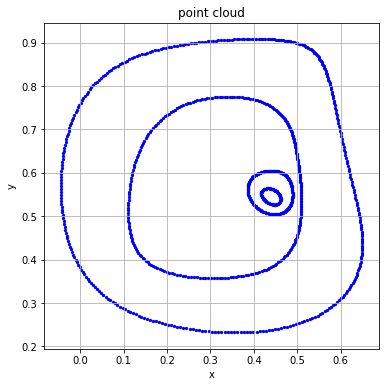

In [8]:
show_point_set(pts, "point cloud")

In [18]:
curvatures = calc_curvature(pts, pts_left, pts_right)

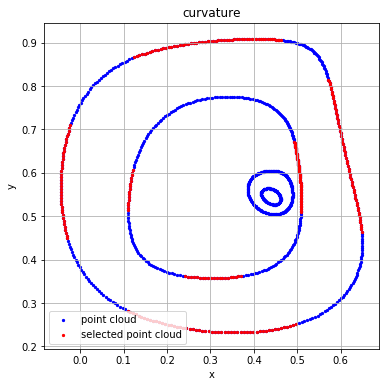

In [19]:
show_point_set_curvature(pts, curvatures, "curvature", 3)

In [20]:
normals = orient_normals(calc_normal(pts, 0.02), pts_left, pts_right)

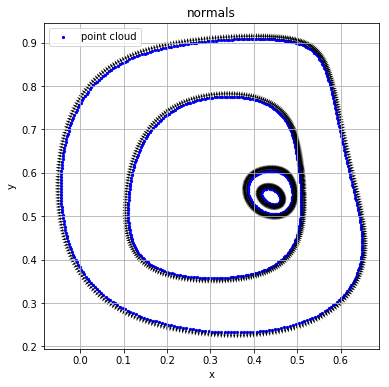

In [21]:
show_point_set_normal(pts, -normals, "normals")

In [11]:
def calc_curvature(pts, connect_left, connect_right):
    
    N = len(pts)
    
    dx = (pts[connect_right][:, 0] - pts[connect_left][:, 0]) / 2.0
    dy = (pts[connect_right][:, 1] - pts[connect_left][:, 1]) / 2.0
    dxx = (dx[connect_right] - dx[connect_left]) / 2.0
    dyy = (dy[connect_right] - dy[connect_left]) / 2.0
    
    numerator = dx * dyy - dxx * dy
    denominator = np.power(dx * dx + dy * dy, 1.5)
    
    return numerator / denominator

In [12]:
def calc_normal(pts, radius = 0.1):
    
    my_tree = KDTree(pts, 10)
    nbs_list = my_tree.query_radius(pts, radius)
    normals = np.zeros((len(pts), 2))
    
    for i, nbs in enumerate(nbs_list):
        my_nbs = pts[nbs]
        eigen_vectors, _ = standard_pca(data_preprocessing(my_nbs)[0])
        normals[i] = eigen_vectors[:, -1] 
        
    normals = normals / np.linalg.norm(normals, axis = 1, keepdims = True)
        
    return normals

In [13]:
def standard_pca(X):
    """
    Params:
        X (np.array): the centralized point 
    Returns:
        q (np.array): of size dim x dim, covariance matrix
    """
    
    q = np.dot(X.T, X) / len(X)
    val_eigen, vec_eigen = np.linalg.eigh(q)

    return vec_eigen[:, ::-1], val_eigen[::-1].reshape((1, -1))

In [14]:
def orient_normals(normals, connect_left, connect_right):
    
    new_normals = deepcopy(normals)
    
    for i in range(len(normals)):
        if connect_right[i] > i:
            pass
        else:
            next_idx = connect_left[i]
            if np.dot(new_normals[i], new_normals[next_idx]) < 0:
                new_normals[next_idx] = -new_normals[next_idx]
                #print(next_idx)
    
    return new_normals

$R = [\cos \beta, -\sin \beta; \sin \beta, \cos \beta]$

In [45]:
def estimate_transform(point_1, point_2, normal_1, normal_2, curvature_1, curvature_2):
    # Find the transformation from point 1 to point 2
    
    # anti-clockwise: 1, clockwise: -1
    x = np.array([0, 1])
    flag_dir = 1 if np.dot(x, normal_1) >= np.dot(x, normal_2) else -1
    
    theta = np.arccos(np.clip(np.dot(normal_1, normal_2), None, 1.)) * flag_dir
    T = np.zeros((3, 3))
    # Rotation
    T[0, 0] = np.cos(theta)
    T[0, 1] = -np.sin(theta)
    T[1, 0] = np.sin(theta)
    T[1, 1] = np.cos(theta)
    
    # Scale
    T[2, 2] = np.abs(curvature_2 / curvature_1)
    
    # Translation
    offset = point_2 - T[:2, :2].dot(point_1) * T[2, 2]
    T[:2, -1] = offset
    
    return T

In [16]:
def transform_neighbors(point_1, point_2, pts, tree, T, radius = 0.02):
    
    neighbors_1 = pts[tree.query_radius(point_1.reshape((1, -1)), radius)[0]]
    new_neighbors = neighbors_1.dot(T[:2, :2].T) * T[2, 2] + T[:2, -1]
    max_dist = np.max(np.linalg.norm(new_neighbors - point_2, axis = 1))
    neighbors_2 = pts[tree.query_radius(point_2.reshape((1, -1)), max_dist + 0.01)[0]]
    
    distances = np.min(pairwise_distances(new_neighbors, neighbors_2), axis = 1)
    
    return neighbors_1, neighbors_2, new_neighbors, distances.sum() / len(distances)

In [17]:
def show_transformed_point_set(points, normals, curvatures, tree, index_1, index_2, save_path = None):
    """ Show a point cloud in 2d
    Params:
        points (np.array): point cloud
        title       (str): title of the plot
        save_path   (str): where to save the plot
    """
    dim = points.shape[1]
    assert(dim == 2), "Only data in 2 dimension space can be visualized."
    
    T = estimate_transform(points[index_1], points[index_2], normals[index_1], normals[index_2], 
                           curvatures[index_1], curvatures[index_2])
    points_1, points_2, points_12, loss = transform_neighbors(points[index_1], points[index_2], points, tree, T)
    
    fig = plt.figure(figsize = (6, 6))
    plt.title("Loss = %f" % loss)
    plt.scatter(points_1[:, 0], points_1[:, 1], s = 5, label = "point cloud 1")
    plt.scatter(points_2[:, 0], points_2[:, 1], s = 5, label = "point cloud 2")
    plt.scatter(points_12[:, 0], points_12[:, 1], s = 5, label = "point cloud 1 to 2")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.grid()
    plt.legend()
    plt.show()
    
    if type(save_path) != type(None):
        fig.savefig(save_path)

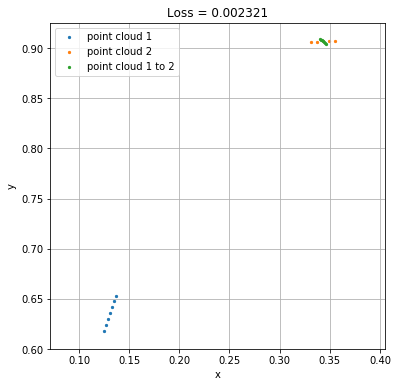

In [50]:
show_transformed_point_set(pts, normals, curvatures, my_tree, 465, 30)

In [23]:
T = estimate_transform(pts[500], pts[0], normals[500], normals[0], curvatures[500], curvatures[0])

In [24]:
my_tree = KDTree(pts, 10)

In [25]:
pts_1, pts_2, pts_12, loss = transform_neighbors(pts[500], pts[0], pts, my_tree, T)

In [65]:
def point_pairing(points, normals, curvatures, tree, ratio = 0.2, thresh = 0.003):
    
    selected_num = int(ratio * len(points))
    selected_idx = np.random.choice(len(points), selected_num, replace = False)
    lT = []
    dict_index = {}
    index = 0
    
    for i in selected_idx:
        for j in range(len(points)):
            if i == j:
                pass
            T = estimate_transform(points[i], points[j], normals[i], normals[j], curvatures[i], curvatures[j])
            loss = transform_neighbors(points[i], points[j], points, tree, T)[-1]
            
            if loss < thresh:
                lT.append(T)
                dict_index[index] = tuple((i, j))
                index += 1
                
    lT = np.stack(lT)
    
    return lT, dict_index

In [66]:
sample_idx = np.arange(0, len(pts), 4)
sample_tree = KDTree(pts[sample_idx], 10)
Ts, dict_index = point_pairing(pts[sample_idx], normals[sample_idx], curvatures[sample_idx], sample_tree)

* Logarithm map

$$
T = \begin{pmatrix}
\cos \theta & -\sin \theta & v_1 \\
\sin \theta & \cos \theta & v_2 \\
0 & 0 & s
\end{pmatrix}
\to
\log T = \begin{pmatrix}
0 & -\theta & x_1 \\
\theta & 0 & x_2 \\
0 & 0 & \lambda
\end{pmatrix}
$$

where:

$$
\begin{align*}
\lambda &= \log s \\
x_1 &= \cfrac{\theta \sin \theta}{2(1 - \cos \theta)} v_1 + \cfrac{\theta}{2} v_2 \\
x_2 &= \cfrac{\theta \sin \theta}{2(1 - \cos \theta)} v_2 - \cfrac{\theta}{2} v_1 
\end{align*}
$$

* Exponential map

$$
\log T = \begin{pmatrix}
0 & -\theta & x_1 \\
\theta & 0 & x_2 \\
0 & 0 & \lambda
\end{pmatrix}
\to
T = \begin{pmatrix}
\cos \theta & -\sin \theta & v_1 \\
\sin \theta & \cos \theta & v_2 \\
0 & 0 & s
\end{pmatrix}
$$

where:

$$
\begin{align*}
s &= \exp \lambda \\
v_1 &= \cfrac{\sin \theta}{\theta} x_1 - \cfrac{1 - \cos \theta}{\theta} x_2 \\
v_2 &= \cfrac{\sin \theta}{\theta} x_2 + \cfrac{1 - \cos \theta}{\theta} x_1 
\end{align*}
$$

In [55]:
def sim2_log(mat, theta = None):
    
    log_mat = np.zeros((4,))
    
    if theta is  None:
        theta = np.arccos(mat[0, 0])
        sign = 1 if mat[1, 0] > 0 else -1
        theta = (theta * sign) % (2 * np.pi)
        
    log_mat[2] = theta
    
    param_a = theta * mat[1, 0] / np.clip(2 * (1 - mat[0, 0]), 1e-6, None)
    param_b = theta / 2
    
    log_mat[0] = param_a * mat[0, 2] + param_b * mat[1, 2]
    log_mat[1] = param_a * mat[1, 2] - param_b * mat[0, 2]

    log_mat[3] = np.log(mat[2, 2])
    
    return log_mat

In [40]:
def sim2_exp(log_mat):
    
    mat = np.zeros((3, 3))
    
    theta = log_mat[2]
    mat[0, 0] = np.cos(theta)
    mat[0, 1] = -np.sin(theta)
    mat[1, 0] = np.sin(theta)
    mat[1, 1] = np.cos(theta)
    
    mat[2, 2] = np.exp(log_mat[3])
    
    param_a = mat[1, 0] / theta
    param_b = (1 - mat[1, 1]) / theta
    mat[0, 2] = param_a * log_mat[0] - param_b * log_mat[1]
    mat[1, 2] = param_b * log_mat[0] + param_a * log_mat[1]

    return mat

In [67]:
log_ts = np.zeros((len(Ts), 4))

for i in range(len(Ts)):
    log_ts[i] = sim2_log(Ts[i])

In [77]:
log_ts[476] = np.zeros((4,))

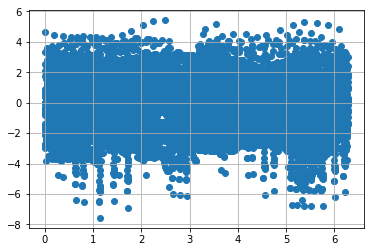

In [83]:
plt.scatter(log_ts[:, 2], log_ts[:, 3])
plt.grid()